# Artificial Intelligence Nanodegree
## Machine Translation Project
In this notebook, sections that end with **'(IMPLEMENTATION)'** in the header indicate that the following blocks of code will require additional functionality which you must provide. Please be sure to read the instructions carefully!

## Introduction
In this notebook, you will build a deep neural network that functions as part of an end-to-end machine translation pipeline. Your completed pipeline will accept English text as input and return the French translation.

- **Preprocess** - You'll convert text to sequence of integers.
- **Models** Create models which <font color='red'>accepts a sequence of integers as input and returns a probability distribution over possible translations.</font> After learning about the basic types of neural networks that are often used for machine translation, you will engage in your own investigations, to design your own model!
- **Prediction** Run the model on English text.

In [1]:
%load_ext autoreload
%aimport helper, tests
%autoreload 1

In [2]:
import collections

import helper
import numpy as np
import project_tests as tests
import matplotlib.pyplot as plt

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential
from keras.layers import GRU, Input, Dense, TimeDistributed, Activation, RepeatVector, Bidirectional, Dropout
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.losses import sparse_categorical_crossentropy

Using TensorFlow backend.


### Verify access to the GPU
The following test applies only if you expect to be using a GPU, e.g., while running in a Udacity Workspace or using an AWS instance with GPU support. Run the next cell, and verify that the device_type is "GPU".
- If the device is not GPU & you are running from a Udacity Workspace, then save your workspace with the icon at the top, then click "enable" at the bottom of the workspace.
- If the device is not GPU & you are running from an AWS instance, then refer to the cloud computing instructions in the classroom to verify your setup steps.

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2915173236249942278
]


## Dataset
We begin by investigating the dataset that will be used to train and evaluate your pipeline.  The most common datasets used for machine translation are from [WMT](http://www.statmt.org/).  However, that will take a long time to train a neural network on.  We'll be using a dataset we created for this project that contains a small vocabulary.  You'll be able to train your model in a reasonable time with this dataset.
### Load Data
The data is located in `data/small_vocab_en` and `data/small_vocab_fr`. The `small_vocab_en` file contains English sentences with their French translations in the `small_vocab_fr` file. Load the English and French data from these files from running the cell below.

In [4]:
# Load English data
english_sentences = helper.load_data('data/small_vocab_en')
# Load French data
french_sentences = helper.load_data('data/small_vocab_fr')

print('Dataset Loaded')

Dataset Loaded


### Files
Each line in `small_vocab_en` contains an English sentence with the respective translation in each line of `small_vocab_fr`.  View the first two lines from each file.

In [5]:
for sample_i in range(2):
    print('small_vocab_en Line {}:  {}'.format(sample_i + 1, english_sentences[sample_i]))
    print('small_vocab_fr Line {}:  {}'.format(sample_i + 1, french_sentences[sample_i]))

small_vocab_en Line 1:  new jersey is sometimes quiet during autumn , and it is snowy in april .
small_vocab_fr Line 1:  new jersey est parfois calme pendant l' automne , et il est neigeux en avril .
small_vocab_en Line 2:  the united states is usually chilly during july , and it is usually freezing in november .
small_vocab_fr Line 2:  les états-unis est généralement froid en juillet , et il gèle habituellement en novembre .


From looking at the sentences, you can see they have been preprocessed already.  The puncuations have been delimited using spaces. All the text have been converted to lowercase.  This should save you some time, but the text requires more preprocessing.
### Vocabulary
The complexity of the problem is determined by the complexity of the vocabulary.  A more complex vocabulary is a more complex problem.  Let's look at the complexity of the dataset we'll be working with.

In [6]:
english_words_counter = collections.Counter([word for sentence in english_sentences for word in sentence.split()])
french_words_counter = collections.Counter([word for sentence in french_sentences for word in sentence.split()])

print('{} English words.'.format(len([word for sentence in english_sentences for word in sentence.split()])))
print('{} unique English words.'.format(len(english_words_counter)))
print('10 Most common words in the English dataset:')
print('"' + '" "'.join(list(zip(*english_words_counter.most_common(10)))[0]) + '"')
print()
print('{} French words.'.format(len([word for sentence in french_sentences for word in sentence.split()])))
print('{} unique French words.'.format(len(french_words_counter)))
print('10 Most common words in the French dataset:')
print('"' + '" "'.join(list(zip(*french_words_counter.most_common(10)))[0]) + '"')

1823250 English words.
227 unique English words.
10 Most common words in the English dataset:
"is" "," "." "in" "it" "during" "the" "but" "and" "sometimes"

1961295 French words.
355 unique French words.
10 Most common words in the French dataset:
"est" "." "," "en" "il" "les" "mais" "et" "la" "parfois"


For comparison, _Alice's Adventures in Wonderland_ contains 2,766 unique words of a total of 15,500 words.
## Preprocess
For this project, you won't use text data as input to your model. Instead, you'll <font color='red'>convert the text into sequences of integers</font> using the following preprocess methods:  
1. <font color='blue'>Tokenize the words into ids. (represent words as integer indexes)</font>
2. <font color='blue'>Add padding to make all the sequences the same length. (all sentences have the same length(time steps, in LSTM terminology))</font>

Time to start preprocessing the data...
### Tokenize (IMPLEMENTATION)
For a neural network to predict on text data, it first has to be turned into data it can understand. <font color='red'>Text data like "dog" is a sequence of ASCII character encodings.</font>  Since a neural network is a series of multiplication and addition operations, <font color='red'>the input data needs to be number(s).</font>

We can <font color='red'>turn each character into a number or each word into a number</font>.  These are called <font color='red'>character and word ids</font>, respectively.  Character ids are used for character level models that generate text predictions for each character.  A word level model uses word ids that generate text predictions for each word.  Word level models tend to learn better, since they are lower in complexity, so we'll use those.

<font color='red'>Turn each sentence into a sequence of words ids</font> using Keras's [`Tokenizer`](https://keras.io/preprocessing/text/#tokenizer) function. Use this function to tokenize `english_sentences` and `french_sentences` in the cell below.

Running the cell will run `tokenize` on sample data and show output for debugging.

In [7]:
def tokenize(x):
    """
    Tokenize x
    :param x: List of sentences/strings to be tokenized
    :return: Tuple of (tokenized x data, tokenizer used to tokenize x)
    """
    # TODO: Implement
    x_tk = Tokenizer(char_level=False)
    x_tk.fit_on_texts(x)
    return x_tk.texts_to_sequences(x), x_tk

tests.test_tokenize(tokenize)

# Tokenize Example output
text_sentences = [
    'The quick brown fox jumps over the lazy dog .',
    'By Jove , my quick study of lexicography won a prize .',
    'This is a short sentence .']
text_tokenized, text_tokenizer = tokenize(text_sentences)
print(text_tokenizer.word_index)
print()
for sample_i, (sent, token_sent) in enumerate(zip(text_sentences, text_tokenized)):
    print('Sequence {} in x'.format(sample_i + 1))
    print('  Input:  {}'.format(sent))
    print('  Output: {}'.format(token_sent))

{'the': 1, 'quick': 2, 'a': 3, 'brown': 4, 'fox': 5, 'jumps': 6, 'over': 7, 'lazy': 8, 'dog': 9, 'by': 10, 'jove': 11, 'my': 12, 'study': 13, 'of': 14, 'lexicography': 15, 'won': 16, 'prize': 17, 'this': 18, 'is': 19, 'short': 20, 'sentence': 21}

Sequence 1 in x
  Input:  The quick brown fox jumps over the lazy dog .
  Output: [1, 2, 4, 5, 6, 7, 1, 8, 9]
Sequence 2 in x
  Input:  By Jove , my quick study of lexicography won a prize .
  Output: [10, 11, 12, 2, 13, 14, 15, 16, 3, 17]
Sequence 3 in x
  Input:  This is a short sentence .
  Output: [18, 19, 3, 20, 21]


### Padding (IMPLEMENTATION)
<font color='red'>When batching the sequence of word ids together, each sequence needs to be the same length.</font>  Since sentences are dynamic in length, we can add padding to the end of the sequences to make them the same length.

<font color='red'>Make sure all the English sequences have the same length and all the French sequences have the same length by adding padding to the <font color='blue'>**end**</font> of each sequence</font> using Keras's [`pad_sequences`](https://keras.io/preprocessing/sequence/#pad_sequences) function.

In [8]:
def pad(x, length=None):
    """
    Pad x
    :param x: List of sequences.
    :param length: Length to pad the sequence to.  If None, use length of longest sequence in x.
    :return: Padded numpy array of sequences
    """
    # TODO: Implement
    if(length is None):
        length = max([len(sentence) for sentence in x])
    return pad_sequences(sequences=x, maxlen=length, padding='post') # since we capture the maximum sentence length, truncation will not happen, so leave argument 'truncating' as default 'pre'.

tests.test_pad(pad)

# Pad Tokenized output
test_pad = pad(text_tokenized)
for sample_i, (token_sent, pad_sent) in enumerate(zip(text_tokenized, test_pad)):
    print('Sequence {} in x'.format(sample_i + 1))
    print('  Input:  {}'.format(np.array(token_sent)))
    print('  Output: {}'.format(pad_sent))

Sequence 1 in x
  Input:  [1 2 4 5 6 7 1 8 9]
  Output: [1 2 4 5 6 7 1 8 9 0]
Sequence 2 in x
  Input:  [10 11 12  2 13 14 15 16  3 17]
  Output: [10 11 12  2 13 14 15 16  3 17]
Sequence 3 in x
  Input:  [18 19  3 20 21]
  Output: [18 19  3 20 21  0  0  0  0  0]


### Preprocess Pipeline
Your focus for this project is to build neural network architecture, so we won't ask you to create a preprocess pipeline.  Instead, we've provided you with the implementation of the `preprocess` function.

#### <font color='red'>***Notes:***</font>
**preproc_<font color='blue'>english</font>_sentences - shape (137861, 15)**:  
Each english sentence has been tokenized to multiple individual <font color='blue'>english</font> words each of which is then converted to an integer representing an <font color='blue'>english</font> word index.  
i.e., "new jersey is sometimes quiet during autumn , and it is snowy in april ." ==>
```python
array([17, 23,  1,  8, 67,  4, 39,  7,  3,  1, 55,  2, 44,  0,  0]) # with shape (15,)
```

**preproc_<font color='orange'>french</font>_sentences - shape (137861, 21, 1)**:  
Each french sentence has been tokenized to multiple individual <font color='orange'>french</font> words each of which is then converted to an integer representing a <font color='orange'>french</font> word index. What's more, label ```preprocess_y``` has been reshaped from 2D (137861, 21) to 3D (137861, 21, 1) since Keras's ```sparse_categorical_crossentropy``` function requires **the labels to be in 3 dimensions**
i.e., "new jersey est parfois calme pendant l' automne , et il est neigeux en avril ." ==>
```python
array([[ 35],
       [ 34],
       [  1],
       [  8],
       [ 67],
       [ 37],
       [ 11],
       [ 24],
       [  6],
       [  3],
       [  1],
       [112],
       [  2],
       [ 50],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0]]) # with shape (21,1)
```

**ndarray.reshape()**:
```python
preprocess_y.reshape(*preprocess_y.shape, 1)  
==> preprocess_y.reshape((*preprocess_y.shape, 1))  
==> preprocess_y.reshape((preprocess_y.shape[0], preprocess_y.shape[1], 1))
# * - break the tuple, i.e., preprocess_y.shape => (137861, 21), however, *preprocess_y.shape => 137861 21
```

In [31]:
print(len(french_tokenizer.word_index), french_tokenizer.word_index)

344 {'est': 1, 'en': 2, 'il': 3, 'les': 4, 'mais': 5, 'et': 6, 'la': 7, 'parfois': 8, 'jamais': 9, 'le': 10, "l'": 11, 'généralement': 12, 'moins': 13, 'aimé': 14, 'au': 15, 'fruit': 16, 'préféré': 17, 'agréable': 18, 'froid': 19, 'son': 20, 'chaud': 21, 'de': 22, 'plus': 23, 'automne': 24, 'mois': 25, 'à': 26, 'elle': 27, 'citrons': 28, 'paris': 29, 'inde': 30, 'unis': 31, 'états': 32, 'france': 33, 'jersey': 34, 'new': 35, 'chine': 36, 'pendant': 37, 'pamplemousse': 38, 'mon': 39, 'votre': 40, 'juin': 41, 'printemps': 42, 'janvier': 43, 'hiver': 44, 'mars': 45, 'été': 46, 'mai': 47, 'septembre': 48, 'juillet': 49, 'avril': 50, 'novembre': 51, 'décembre': 52, 'février': 53, 'octobre': 54, 'aime': 55, 'août': 56, 'merveilleux': 57, 'relaxant': 58, 'doux': 59, 'humide': 60, 'notre': 61, 'californie': 62, 'sec': 63, 'leur': 64, 'occupé': 65, 'pluvieux': 66, 'calme': 67, 'beau': 68, 'habituellement': 69, 'pommes': 70, 'pêches': 71, 'oranges': 72, 'poires': 73, 'fraises': 74, 'bananes': 75

In [32]:
print(len(english_tokenizer.word_index), english_tokenizer.word_index)

199 {'is': 1, 'in': 2, 'it': 3, 'during': 4, 'the': 5, 'but': 6, 'and': 7, 'sometimes': 8, 'usually': 9, 'never': 10, 'favorite': 11, 'least': 12, 'fruit': 13, 'most': 14, 'loved': 15, 'liked': 16, 'new': 17, 'paris': 18, 'india': 19, 'united': 20, 'states': 21, 'california': 22, 'jersey': 23, 'france': 24, 'china': 25, 'he': 26, 'she': 27, 'grapefruit': 28, 'your': 29, 'my': 30, 'his': 31, 'her': 32, 'fall': 33, 'june': 34, 'spring': 35, 'january': 36, 'winter': 37, 'march': 38, 'autumn': 39, 'may': 40, 'nice': 41, 'september': 42, 'july': 43, 'april': 44, 'november': 45, 'summer': 46, 'december': 47, 'february': 48, 'our': 49, 'their': 50, 'freezing': 51, 'pleasant': 52, 'beautiful': 53, 'october': 54, 'snowy': 55, 'warm': 56, 'cold': 57, 'wonderful': 58, 'dry': 59, 'busy': 60, 'august': 61, 'chilly': 62, 'rainy': 63, 'mild': 64, 'wet': 65, 'relaxing': 66, 'quiet': 67, 'hot': 68, 'dislikes': 69, 'likes': 70, 'limes': 71, 'lemons': 72, 'grapes': 73, 'mangoes': 74, 'apples': 75, 'peach

In [9]:
def preprocess(x, y):
    """
    Preprocess x and y
    :param x: Feature List of sentences
    :param y: Label List of sentences
    :return: Tuple of (Preprocessed x, Preprocessed y, x tokenizer, y tokenizer)
    """
    preprocess_x, x_tk = tokenize(x)
    preprocess_y, y_tk = tokenize(y)

    preprocess_x = pad(preprocess_x)
    preprocess_y = pad(preprocess_y)

    # Keras's sparse_categorical_crossentropy function requires the labels to be in 3 dimensions
    preprocess_y = preprocess_y.reshape(*preprocess_y.shape, 1)

    return preprocess_x, preprocess_y, x_tk, y_tk

preproc_english_sentences, preproc_french_sentences, english_tokenizer, french_tokenizer =\
    preprocess(english_sentences, french_sentences)
    
max_english_sequence_length = preproc_english_sentences.shape[1]
max_french_sequence_length = preproc_french_sentences.shape[1]
english_vocab_size = len(english_tokenizer.word_index)
french_vocab_size = len(french_tokenizer.word_index)

print('Data Preprocessed')
print("Max English sentence length:", max_english_sequence_length)
print("Max French sentence length:", max_french_sequence_length)
print("English vocabulary size:", english_vocab_size)
print("French vocabulary size:", french_vocab_size)

Data Preprocessed
Max English sentence length: 15
Max French sentence length: 21
English vocabulary size: 199
French vocabulary size: 344


## Models
In this section, you will experiment with various neural network architectures.
You will begin by training four relatively simple architectures.
- Model 1 is a simple RNN
- Model 2 is a RNN with Embedding
- Model 3 is a Bidirectional RNN
- Model 4 is an optional Encoder-Decoder RNN

After experimenting with the four simple architectures, you will construct a deeper architecture that is designed to outperform all four models.
### Ids Back to Text
The neural network will be translating the input to words ids, which isn't the final form we want.  We want the French translation.  The function `logits_to_text` will bridge the gab between the logits from the neural network to the French translation.  You'll be using this function to better understand the output of the neural network.

In [10]:
def logits_to_text(logits, tokenizer):
    """
    Turn logits from a neural network into text using the tokenizer
    :param logits: Logits from a neural network
    :param tokenizer: Keras Tokenizer fit on the labels
    :return: String that represents the text of the logits
    """
    index_to_words = {id: word for word, id in tokenizer.word_index.items()}
    index_to_words[0] = '<PAD>'

    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])

print('`logits_to_text` function loaded.')

`logits_to_text` function loaded.


### Model 1: RNN (IMPLEMENTATION)
![RNN](images/rnn.png)
A basic RNN model is a good baseline for sequence data.  In this model, you'll build a RNN that translates English to French.

In [11]:
# Explanations: "tmp_x = pad(preproc_english_sentences, max_french_sequence_length)"
print(f"english length - {len(preproc_english_sentences[0])}, {preproc_english_sentences[0]}")
print(f"french length - {len(pad(preproc_english_sentences[:3], 21)[0])}, {pad(preproc_english_sentences[:3], 21)[0]}")

english length - 15, [17 23  1  8 67  4 39  7  3  1 55  2 44  0  0]
french length - 21, [17 23  1  8 67  4 39  7  3  1 55  2 44  0  0  0  0  0  0  0  0]


In [12]:
example_tmp_x = pad(preproc_english_sentences, max_french_sequence_length)
example_tmp_x_reshape = example_tmp_x.reshape((-1, preproc_french_sentences.shape[1], 1))

print(example_tmp_x.shape)
print(example_tmp_x_reshape.shape)

# 3-dimension array: (number_of_sequences(sentences), number_of_words_in_each_sequence(sentence), number_of_element_in_each_dimension(1 here, represent a word index))

(137861, 21)
(137861, 21, 1)


In [13]:
# Reference link: https://stackoverflow.com/questions/22053050/difference-between-numpy-array-shape-r-1-and-r
print(f"1 dimension array with 21 elements, shape = {example_tmp_x[0].shape}:")
print(example_tmp_x[0])
print(f"21 dimensions array, each dimension has 1 element, shape = {example_tmp_x_reshape[0].shape}:")
print(example_tmp_x_reshape[0])

1 dimension array with 21 elements, shape = (21,):
[17 23  1  8 67  4 39  7  3  1 55  2 44  0  0  0  0  0  0  0  0]
21 dimensions array, each dimension has 1 element, shape = (21, 1):
[[17]
 [23]
 [ 1]
 [ 8]
 [67]
 [ 4]
 [39]
 [ 7]
 [ 3]
 [ 1]
 [55]
 [ 2]
 [44]
 [ 0]
 [ 0]
 [ 0]
 [ 0]
 [ 0]
 [ 0]
 [ 0]
 [ 0]]


<font color='red'>***Notes:***</font>  
**GRU Layer input shape** - 3D tensor: [batch_size, timesteps, num_of_features]  
[reference link](https://stackoverflow.com/questions/47268608/confusion-about-keras-rnn-input-shape-requirement)  
***("timesteps" and "sequence_length" can be used interchangeably)***  
- **batch_size**: we can divide all 137861 sequences(sentences) into multiple chunks with same number of unique sequences(sentences). For example, batch_size=32 means we take the first 32 sequences(sentences) as a batch chunk, then 33-64th sequences(sentences) as a batch chunk, ..., until the last batch chunk (even though not enough 32 sequences/sentences).
- **timesteps**: each sentence now have the same length of 15(in english words) or 21(in french words), so <font color='red'>timesteps here is **21**</font> since we are translating english to french, meaning inputs are in english but labels are in french, need to match the timesteps with labels.  
- **num_of_features**: each word index is a feature, since each sequence/sentence has been converted to a (21,1) 2D array, so <font color='red'>here the value should be 1</font> representing one integer (each word index in each sequence/sentence).  

**TimeDistributed Dense Layer**:  
[reference link](https://machinelearningmastery.com/timedistributed-layer-for-long-short-term-memory-networks-in-python/)  

**A dense layer is a fully-connected layer**. The terminology "dense layer" and "fully-connected layer" are used interchangeably.  

<font color='red'>**!!! Why does ```input_shape``` argument have value ```input_shape[1:]``` rather than ```input_shape```?**:</font>  
[reference link](https://github.com/keras-team/keras/issues/7403)  
Keras' convention is that **the batch dimension (number of examples/samples (not the same as timesteps)) is typically <font color='red'>omitted</font> in the input_shape arguments**. The batching (number of examples/samples per batch) is handled in the fit call - ```model.fit(batch=...)```.

The last Dense layer of the model should have ```n_classes``` hidden units. Here, the number of units for the last Dense layer is ```french_vocab_size```.

In [13]:
# Build a basic RNN model with Sequential():

def simple_model_sequential(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build and train a basic RNN on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
    """
    # TODO: Build the layers
    learning_rate = 2e-3
    hidden_state_units = 256
    
    # 2 GRU layers + 2 fully-connected dense layers(TimeDistributed)
    model = Sequential()
    model.add(GRU(units=hidden_state_units, activation='relu', dropout=0.3, return_sequences=True, input_shape=input_shape[1:]))
    model.add(GRU(units=hidden_state_units, activation='relu', dropout=0.3, return_sequences=True))
    model.add(TimeDistributed(Dense(units=1024, activation='relu')))
    model.add(Dropout(0.3))
    model.add(TimeDistributed(Dense(units=french_vocab_size, activation='softmax'))) 
    
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
    return model

In [14]:
# Build a basic RNN by defining each layer separately:

def simple_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build and train a basic RNN on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
    """
    # TODO: Build the layers
    learning_rate = 2e-3
    hidden_state_units = 256
    
    inputs = Input(shape=input_shape[1:]) # here the shape is a tuple (integers) NOT including the batch size - meaning (timesteps, num_of_features) - reference link: https://keras.io/api/layers/core_layers/input/
    hidden_state_1 = GRU(units=hidden_state_units, return_sequences=True, dropout=0.3)(inputs)
    hidden_state_2 = GRU(units=hidden_state_units, return_sequences=True, dropout=0.3)(hidden_state_1)
    fully_connect_1 = TimeDistributed(Dense(units=1024, activation='relu'))(hidden_state_2)
    fully_connect_2 = TimeDistributed(Dense(units=french_vocab_size))(fully_connect_1)
    outputs = Activation(activation='softmax')(fully_connect_2)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
    return model

tests.test_simple_model(simple_model)

***<font color='red'>Notes:</font>***  
Input of GRU layer needs to be a 3D tensor (see above notes), and timesteps of the input should be equivalant to the output.  
For example, here we need to do the following:  
- (1). post-pad 0 on all sentences within preproc_english_sentences so that each english sentence now has the same length of 21 which is the maximum frenche sentence length;  
- (2). reshape this **new** preproc_english_sentences from 2D tensor with shape (137861, 21) to 3D tensor with shape (137861, 21, 1).  

Note that original ```preproc_english_sentences``` has shape (137861, 15), however, since we applied the zero-post-padding in step (1), so the **new**```preproc_english_sentences``` now has **new** shape (137861, 21).  

**<font color='red'>One important thing</font>**, <font color='blue'>although the input of GRU layer is a 3D tensor, the ```input_shape``` argument in ```GRU(..., input_shape=...)``` should be set as ```tmp_x.shape[1:]``` rather than ```tmp_x.shape```.</font> The reason is that batch dimension (batch_size) is omitted in ```input_shape``` argument, instead, its value is set in ```.fit(batch=...)```. Same for ```Input(shape=...)```, here should be ```tmp_x.shape[1:]```, you can ignore the ```batch_shape``` argument here and set it in ```.fit(batch=...)```.  
(see above notes)

In [11]:
# Reshaping the input to work with a basic RNN
# Why reshape tmp_x from 2D tensor to 3D tensor? - see above cell
# GRU layer accepts a 3D tensor with shape [batch_size, timesteps, num_of_feature] ==> [-1, preproc_french_sentences.shape[-2], 1]
# reference link: https://keras.io/api/layers/recurrent_layers/gru/

tmp_x = pad(preproc_english_sentences, max_french_sequence_length) # convert english sentences (all have converted to maximum engligh-length 15) to have the same length as maximum french-length 21
tmp_x = tmp_x.reshape((-1, preproc_french_sentences.shape[-2], 1)) # here is a 3D tensor, reshape tmp_x from 2D - (137861, 21) to 3D - (137861, 21, 1)

In [17]:
# TODO: Train the neural network (SimpleRNN)
simple_rnn_model = simple_model(
    tmp_x.shape,
    max_french_sequence_length,
    english_vocab_size+1, # len(english_vocab_size)+1 == english_vocab_size+1, if not set as vocabulary size + 1, then val_loss will be nan
    french_vocab_size+1) # len(french_vocab_size)+1 == french_vocab_size+1, if not set as vocabulary size + 1, then val_loss will be nan

print(simple_rnn_model.summary())

history_simple_rnn = simple_rnn_model.fit(tmp_x, preproc_french_sentences, batch_size=2048, epochs=10, validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 21, 1)             0         
_________________________________________________________________
gru_3 (GRU)                  (None, 21, 256)           198144    
_________________________________________________________________
gru_4 (GRU)                  (None, 21, 256)           393984    
_________________________________________________________________
time_distributed_3 (TimeDist (None, 21, 1024)          263168    
_________________________________________________________________
time_distributed_4 (TimeDist (None, 21, 345)           353625    
_________________________________________________________________
activation_2 (Activation)    (None, 21, 345)           0         
Total params: 1,208,921
Trainable params: 1,208,921
Non-trainable params: 0
_________________________________________________________________


In [19]:
# TODO: Print prediction(s)
print(f"English: \n{english_sentences[1]}")
print(f"French: \n{french_sentences[1]}")
print()
print(f"Machine translation in French: \n{logits_to_text(simple_rnn_model.predict(tmp_x[:2])[1], french_tokenizer).replace('<PAD> ','').replace(' <PAD> ','').replace(' <PAD>','')}")

English: 
the united states is usually chilly during july , and it is usually freezing in november .
French: 
les états-unis est généralement froid en juillet , et il gèle habituellement en novembre .

Machine translation in French: 
les états unis est parfois agréable en juin mais il est est agréable en l'


<font color='red'>***Notes:***</font>  
<font color='red'>**Thoughts on the results:**</font>  
As the epoch goes up, the accuracy increases slowly. Although I tried to increase the batch_size from 1024 to 2048 so that the model will have more data to train before updating weights (in other words, weights get less time to be updated), the benefits were not so quite obvious. I think this is becase of the vanishing gradient problem which leads to those weights getting smaller updates or even no updates (gradient is much close to 0, which stops the network from training)

### Model 2: Embedding (IMPLEMENTATION)
![RNN](images/embedding.png)
<font color='red'>You've turned the words into ids, but there's a better representation of a word</font>.  This is called <font color='red'>word embeddings</font>.  An embedding is a vector representation of the word that is close to similar words in n-dimensional space, where the n represents the size of the embedding vectors.

In this model, you'll <font color='red'>create a RNN model using embedding.</font>

<font color='red'>***Notes:***</font>  
**Embedding Layer input shape** - 2D tensor: [batch_size, input_length]  
***("sequence" and "sentence" can be used interchangeably)***  
- **batch_size**: total number of sequences/sentences in the dataset. "-1" in tmp_x.reshape(<font color='red'>(-1, preproc_french_sentences.shape[1])</font>) for <font color='red'>embedding layer</font> is an unknown dimension and we want numpy to figure it out, numpy will look at the original array and know that the original array has dimension 137861, so that -1 here represents 137861.
- **sequence_length**: [official keras documentation](https://keras.io/layers/embeddings/) write this as input_length which causes confusion, just think of input_length as sequence_length, since each sequence is actually a sentence, thus sequence_length is also sentence_length, and each sentence is now having the same length since we already applied the zero-post-padding before doing ```tmp_x.reshape((-1, preproc_french_sentences.shape[1]))```.   

**Embedding Layer must specify 3 arguments**:
- **input_dim**: size of the vocabulary, (can be maximum integer index + 1). If use embedding on categorical features (Cat2Vec), then this should be the number of unique categories in a categorical feature, i.e. 12(13 if using index + 1) for January(0) to December(11), and 7(8 if using index + 1) for Monday(0) to Sunday(6). Here, the input_dim is english_vocab_size (not using index + 1 here).
- **output_dim**: size of the vector space in "embedding matrix"(if using one-hot encoding) or "lookup table"(if using label encoding). For example, here I want to convert each word(represented by an integer as this word's word index, i.e. label encoding here) to a vector with 300 floats (ventor with 300 dimensions), then output_dim=300. This process is like: (1) map a single integer (i.e. word index) to 300 floats, if label encoding; (2) map a one-hot encoded array say [0,0,1,0] to 300 floats, if one-hot encoding. 
- **input_length**: the length of input sequences. Since we've converted all sequences/sentences with different sentence length originally to have same length (take maximum length from all french sentences as the global length, then post-pad 0 on short sentences), so the input_length here is 21. 


**Remember**, the input_shape argument in ```Embedding(input_shape=...)``` should **<font color='red'>NOT</font>** include batch dimension (batch_size). Since embedding layer accepts a 2D tensor, here it should be set as ```input_shape=tmp_x.shape[1:]```. Put it another way, ```tmp_x.shape[1:]``` is actually ```(21,)``` where 21 is the sequence_length (maximum french sentence length).
[reference link](https://stackoverflow.com/questions/53465475/confusion-about-input-shape-for-keras-embedding-layer)

In [20]:
# Build RNN model with Embedding by using Sequential():

def embed_model_sequential(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build and train a RNN model using word embedding on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset, PLUS 1
    :param french_vocab_size: Number of unique French words in the dataset, PLUS 1
    :return: Keras model built, but not trained
    """
    # Notice that the argument english_vocab_size here is actually vocabulary size + 1 - "len(english_vocab_size)+1"
    # The same to french_vocab_size
    # TODO: Implement
    learning_rate = 2e-3
    hidden_state_units = 256
    embedding_dim = 300
    
    model = Sequential()
    model.add(Embedding(input_dim=english_vocab_size, output_dim=embedding_dim, input_length=input_shape[1], input_shape=input_shape[1:]))
    model.add(GRU(units=hidden_state_units, activation='relu', return_sequences=True, dropout=0.3))
    model.add(GRU(units=hidden_state_units, activation='relu', return_sequences=True, dropout=0.3))
    model.add(TimeDistributed(Dense(units=1024, activation='relu')))
    model.add(Dropout(0.3))
    model.add(TimeDistributed(Dense(units=french_vocab_size, activation='softmax')))

    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
    return model

In [22]:
# Build RNN model with Embedding and define each layer separately:

def embed_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build and train a RNN model using word embedding on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset, PLUS 1
    :param french_vocab_size: Number of unique French words in the dataset, PLUS 1
    :return: Keras model built, but not trained
    """
    # Notice that the argument english_vocab_size here is actually vocabulary size + 1 - "len(english_vocab_size)+1"
    # The same to french_vocab_size
    # TODO: Implement
    learning_rate = 2e-3
    hidden_state_units = 256
    embedding_dim = 300
    
    inputs = Input(shape=input_shape[1:]) # here the shape is a tuple (integers) NOT including the batch size - meaning (timesteps, num_of_features) - reference link: https://keras.io/api/layers/core_layers/input/
    word_embedding = Embedding(input_dim=english_vocab_size, output_dim=embedding_dim, input_length=input_shape[1])(inputs)
    hidden_state_1 = GRU(units=hidden_state_units, activation='relu', return_sequences=True, dropout=0.3)(word_embedding)
    hidden_state_2 = GRU(units=hidden_state_units, activation='relu', return_sequences=True, dropout=0.3)(hidden_state_1)
    fully_connect_1 = TimeDistributed(Dense(units=1024, activation='relu'))(hidden_state_2)
    fully_connect_2 = TimeDistributed(Dense(units=french_vocab_size))(fully_connect_1)
    outputs = Activation(activation='softmax')(fully_connect_2)
    
    model = Model(inputs=inputs, outputs=outputs)

    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
    return model

tests.test_embed_model(embed_model)

In [23]:
# TODO: Reshape the input
# max_french_sequence_length == preproc_french_sentences.shape[1]
tmp_x = pad(preproc_english_sentences, max_french_sequence_length)
tmp_x = tmp_x.reshape((-1, preproc_french_sentences.shape[1])) # here is a 2D tensor

In [24]:
# TODO: Build the neural network
embed_rnn_model_sequential = embed_model_sequential(
    tmp_x.shape,
    max_french_sequence_length, # this argument is not used, I define a custom embedding_dim which is 300
    len(english_tokenizer.word_index)+1,
    len(french_tokenizer.word_index)+1
)

# Model summary:
embed_rnn_model_sequential.summary()

# TODO: Train the neural network (embedding layer + GRU)
history_embed_rnn_sequential = embed_rnn_model_sequential.fit(tmp_x, preproc_french_sentences, batch_size=1024, epochs=20, validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 21, 300)           60000     
_________________________________________________________________
gru_7 (GRU)                  (None, 21, 256)           427776    
_________________________________________________________________
gru_8 (GRU)                  (None, 21, 256)           393984    
_________________________________________________________________
time_distributed_7 (TimeDist (None, 21, 1024)          263168    
_________________________________________________________________
dropout_1 (Dropout)          (None, 21, 1024)          0         
_________________________________________________________________
time_distributed_8 (TimeDist (None, 21, 345)           353625    
Total params: 1,498,553
Trainable params: 1,498,553
Non-trainable params: 0
_________________________________________________________________


In [25]:
# TODO: Print prediction(s)
print(f"English: \n{english_sentences[1]}")
print(f"French: \n{french_sentences[1]}")
print()
print(f"Machine translation in French: \n{logits_to_text(embed_rnn_model_sequential.predict(tmp_x[:2])[1], french_tokenizer).replace('<PAD> ','').replace(' <PAD> ','').replace(' <PAD>','')}")

English: 
the united states is usually chilly during july , and it is usually freezing in november .
French: 
les états-unis est généralement froid en juillet , et il gèle habituellement en novembre .

Machine translation in French: 
les états unis est généralement froid en juillet et il est généralement en décembre


### Model 3: Bidirectional RNNs (IMPLEMENTATION)
![RNN](images/bidirectional.png)
<font color='red'>One restriction of a RNN is that it can't see the future input, only the past.</font>  This is where bidirectional recurrent neural networks come in.  They are able to see the future data.

In [26]:
def bd_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build and train a bidirectional RNN model on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset, PLUS 1
    :param french_vocab_size: Number of unique French words in the dataset, PLUS 1
    :return: Keras model built, but not trained
    """
    # TODO: Implement
    learning_rate = 2e-3
    hidden_state_units = 256
    
    model = Sequential()
    model.add(Bidirectional(layer=GRU(units=hidden_state_units, activation='relu', dropout=0.3, return_sequences=True), input_shape=input_shape[1:]))
    model.add(Bidirectional(layer=GRU(units=hidden_state_units, activation='relu', dropout=0.3, return_sequences=True)))
    model.add(TimeDistributed(Dense(1024, activation='relu')))
    model.add(Dropout(0.3))
    model.add(TimeDistributed(Dense(french_vocab_size, activation='softmax')))

    # Compile model
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
    return model

tests.test_bd_model(bd_model)

In [27]:
def embed_bd_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build and train a bidirectional RNN model on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset, PLUS 1
    :param french_vocab_size: Number of unique French words in the dataset, PLUS 1
    :return: Keras model built, but not trained
    """
    # TODO: Implement
    learning_rate = 2e-3
    hidden_state_units = 256
    embedding_dim = 300
    
    # 1 embedding layer + 1 Bidirectional GRU layer + 2 time distributed dense layers:
    # embedding layer - accepts 2D tensor as input, output 3D tensor
    # bidirectional GRU layer - accepts 3D tensor as input, output 3D tensor
    model = Sequential()
    model.add(Embedding(input_dim=english_vocab_size, output_dim=embedding_dim, input_length=input_shape[1], input_shape=input_shape[1:]))
    model.add(Bidirectional(layer=GRU(units=hidden_state_units, activation='relu', dropout=0.3, return_sequences=True)))
    model.add(TimeDistributed(Dense(1024, activation='relu')))
    model.add(Dropout(0.3))
    model.add(TimeDistributed(Dense(french_vocab_size, activation='softmax')))

    # Compile model
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
    return model

In [28]:
### USING EMBEDDING ###
# TODO: Reshape the input
# Pay attention to the difference of tmp_x.reshape between USING EMBEDDING and NOT USING EMBEDDING
tmp_x = pad(preproc_english_sentences, preproc_french_sentences.shape[1])
tmp_x = tmp_x.reshape((-1, preproc_french_sentences.shape[1])) # 2D tensor - [batch_size, sequence_length]

# TODO: Build the neural network
embed_bd_rnn_model = embed_bd_model(
    tmp_x.shape,
    max_french_sequence_length,
    english_vocab_size+1,
    french_vocab_size+1
)

# Model Summary:
embed_bd_rnn_model.summary()

# TODO: Train the neural network (BRNN)
history_embed_bd_rnn = embed_bd_rnn_model.fit(tmp_x, preproc_french_sentences, batch_size=1024, epochs=20, validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 21, 300)           60000     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 21, 512)           855552    
_________________________________________________________________
time_distributed_11 (TimeDis (None, 21, 1024)          525312    
_________________________________________________________________
dropout_3 (Dropout)          (None, 21, 1024)          0         
_________________________________________________________________
time_distributed_12 (TimeDis (None, 21, 345)           353625    
Total params: 1,794,489
Trainable params: 1,794,489
Non-trainable params: 0
_________________________________________________________________
Train on 110288 samples, validate on 27573 samples
Epoch 1/20
110288/110288 [==============================] - 32s 291us/step - loss

In [29]:
# TODO: Print prediction(s)
print(f"English: \n{english_sentences[1]}")
print(f"French: \n{french_sentences[1]}")
print()
print(f"Machine translation in French: \n{logits_to_text(embed_bd_rnn_model.predict(tmp_x[:2])[1], french_tokenizer).replace('<PAD> ','').replace(' <PAD> ','').replace(' <PAD>','')}")
print("==================")
print(f"English: \n{english_sentences[10]}")
print(f"French: \n{french_sentences[10]}")
print()
print(f"Machine translation in French: \n{logits_to_text(embed_bd_rnn_model.predict(tmp_x[:11])[10], french_tokenizer).replace('<PAD> ','').replace(' <PAD> ','').replace(' <PAD>','')}")
print("==================")
print(f"English: \n{english_sentences[3]}")
print(f"French: \n{french_sentences[3]}")
print()
print(f"Machine translation in French: \n{logits_to_text(embed_bd_rnn_model.predict(tmp_x[:4])[3], french_tokenizer).replace('<PAD> ','').replace(' <PAD> ','').replace(' <PAD>','')}")
print("==================")
print(f"English: \n{english_sentences[8]}")
print(f"French: \n{french_sentences[8]}")
print()
print(f"Machine translation in French: \n{logits_to_text(embed_bd_rnn_model.predict(tmp_x[:9])[8], french_tokenizer).replace('<PAD> ','').replace(' <PAD> ','').replace(' <PAD>','')}")
print("==================")
print(f"English: \n{english_sentences[25]}")
print(f"French: \n{french_sentences[25]}")
print()
print(f"Machine translation in French: \n{logits_to_text(embed_bd_rnn_model.predict(tmp_x[:26])[25], french_tokenizer).replace('<PAD> ','').replace(' <PAD> ','').replace(' <PAD>','')}")

English: 
the united states is usually chilly during july , and it is usually freezing in november .
French: 
les états-unis est généralement froid en juillet , et il gèle habituellement en novembre .

Machine translation in French: 
les états unis est généralement froid en juillet et il gèle habituellement en novembre
English: 
the lime is her least liked fruit , but the banana is my least liked .
French: 
la chaux est son moins aimé des fruits , mais la banane est mon moins aimé.

Machine translation in French: 
la chaux est son moins aimé des fruits mais la banane est mon moins aimé
English: 
the united states is sometimes mild during june , and it is cold in september .
French: 
les états-unis est parfois légère en juin , et il fait froid en septembre .

Machine translation in French: 
les états unis est parfois doux en juin et il fait froid en septembre
English: 
our least liked fruit is the lemon , but my least liked is the grape .
French: 
notre fruit est moins aimé le citron , 

<font color='red'>***Notes:***</font>  
<font color='red'>***Thoughts on the result:***</font>  
Bidirectional RNN with Embedding model translates english to french with a very high accuracy.  

I noticed that if I add one more Bidirectional GRU layer, then the training speed is slowing down. In the mean time, **the training accuracy is increasing slowly, while the validation accuracy is decreasing. Why?** How many bidirectional GRU layers to use?

### Model 4: Encoder-Decoder (OPTIONAL)
Time to look at encoder-decoder models.  This model is made up of an encoder and decoder. The encoder creates a matrix representation of the sentence.  The decoder takes this matrix as input and predicts the translation as output.

Create an encoder-decoder model in the cell below.

In [35]:
def encdec_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build and train an encoder-decoder model on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset, PLUS 1
    :param french_vocab_size: Number of unique French words in the dataset, PLUS 1
    :return: Keras model built, but not trained
    """
    # OPTIONAL: Implement
    learning_rate = 2e-3
    hidden_state_units = 256
    
    model = Sequential()

    # Encoder
    # The encoder network is NOT used to produce any outputs.
    model.add(GRU(units=hidden_state_units, activation='relu', input_shape=input_shape[1:], return_sequences=False, go_backwards=True))

    # Decoder
    # Get the LAST output of the GRU and repeat it
    model.add(RepeatVector(output_sequence_length))
    model.add(GRU(units=hidden_state_units, activation='relu', return_sequences=True))

    # Fully-connected TimeDistributed Dense layer
    model.add(TimeDistributed(Dense(1024, activation='relu')))
    
    # Dropout layer
    model.add(Dropout(0.3))
    
    # (Output layer) Fully-connected TimeDistributed Dense layer
    model.add(TimeDistributed(Dense(french_vocab_size, activation='softmax')))

    # Compile model
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
    return model

tests.test_encdec_model(encdec_model)

In [33]:
# TODO: Reshape the input
tmp_x = pad(preproc_english_sentences, preproc_french_sentences.shape[1])
tmp_x = tmp_x.reshape((-1, preproc_french_sentences.shape[1], 1)) # 3D tensor - [batch_size, timesteps, num_of_features]

In [36]:
# TODO: Build the neural network
encdec_rnn_model = encdec_model(
    tmp_x.shape,
    max_french_sequence_length,
    english_vocab_size+1,
    french_vocab_size+1
)

# Model Summary:
encdec_rnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_22 (GRU)                 (None, 256)               198144    
_________________________________________________________________
repeat_vector_5 (RepeatVecto (None, 21, 256)           0         
_________________________________________________________________
gru_23 (GRU)                 (None, 21, 256)           393984    
_________________________________________________________________
time_distributed_23 (TimeDis (None, 21, 1024)          263168    
_________________________________________________________________
dropout_9 (Dropout)          (None, 21, 1024)          0         
_________________________________________________________________
time_distributed_24 (TimeDis (None, 21, 345)           353625    
Total params: 1,208,921
Trainable params: 1,208,921
Non-trainable params: 0
_________________________________________________________________


In [37]:
# TODO: Train the neural network (BRNN)
history_encdec_rnn = encdec_rnn_model.fit(tmp_x, preproc_french_sentences, batch_size=1024, epochs=20, validation_split=0.2)

Train on 110288 samples, validate on 27573 samples
Epoch 1/20
110288/110288 [==============================] - 26s 239us/step - loss: 2.2351 - acc: 0.4924 - val_loss: 1.5196 - val_acc: 0.5978
Epoch 2/20
110288/110288 [==============================] - 25s 225us/step - loss: 1.4407 - acc: 0.6006 - val_loss: 1.3490 - val_acc: 0.6193
Epoch 3/20
110288/110288 [==============================] - 25s 225us/step - loss: 1.2785 - acc: 0.6328 - val_loss: 1.2073 - val_acc: 0.6480
Epoch 4/20
110288/110288 [==============================] - 25s 225us/step - loss: 1.1628 - acc: 0.6541 - val_loss: 1.0829 - val_acc: 0.6686
Epoch 5/20
110288/110288 [==============================] - 25s 225us/step - loss: 1.0799 - acc: 0.6675 - val_loss: 1.0160 - val_acc: 0.6810
Epoch 6/20
110288/110288 [==============================] - 25s 225us/step - loss: 1.0118 - acc: 0.6794 - val_loss: 0.9280 - val_acc: 0.7024
Epoch 7/20
110288/110288 [==============================] - 25s 225us/step - loss: 0.9384 - acc: 0.6971

### Model 5: Custom (IMPLEMENTATION)
Use everything you learned from the previous models to create a model that incorporates embedding and a bidirectional rnn into one model.

In [38]:
def model_final(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build and train a model that incorporates embedding, encoder-decoder, and bidirectional RNN on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset, PLUS 1
    :param french_vocab_size: Number of unique French words in the dataset, PLUS 1
    :return: Keras model built, but not trained
    """
    # TODO: Implement
    # Hyperparameters
    learning_rate = 5e-3
    hidden_state_units = 128
    embedding_dim = 128

    # Build layers:
    model = Sequential()
    
    # Layer 1 - Embedding layer
    model.add(Embedding(input_dim=english_vocab_size, output_dim=embedding_dim, input_shape=input_shape[1:], input_length=input_shape[1]))
    # Layer 2 - Encoder
    # RepeatVector layer is used to fit 2D output to required 3D input shape [batch_size, timesteps, num_of_features] which will be feed into the next GRU layer
    model.add(Bidirectional(GRU(units=hidden_state_units, activation='relu', dropout=0.3, return_sequences=False)))
    model.add(RepeatVector(n=output_sequence_length)) # n is the timesteps. Here, timesteps is max_french_sequence_length which is the value of function parameter output_sequence_length
    # Layer 3 - Decoder
    model.add(Bidirectional(GRU(units=hidden_state_units, activation='relu', dropout=0.3, return_sequences=True)))
    # Layer 4 - Fully-connected TimeDistributed Dense layer which is applied to every temporal slice of an input
    model.add(TimeDistributed(Dense(512, activation='relu')))
    # Layer 5 - Dropout layer
    model.add(Dropout(0.3))
    # Layer 6 - (Output layer) Fully-connected TimeDistributed Dense layer which is applied to every temporal slice of an input
    model.add(TimeDistributed(Dense(french_vocab_size, activation='softmax')))
    
    # Model Compile:
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
    return model

tests.test_model_final(model_final)

print('Final Model Loaded')

Final Model Loaded


## Prediction (IMPLEMENTATION)

In [48]:
def final_predictions(x, y, x_tk, y_tk):
    """
    Gets predictions using the final model
    :param x: Preprocessed English data
    :param y: Preprocessed French data
    :param x_tk: English tokenizer
    :param y_tk: French tokenizer
    """
    # TODO: Train neural network using model_final
    model = model_final(
        x.shape,
        y.shape[1],
        len(x_tk.word_index)+1,
        len(y_tk.word_index)+1
    )
    model.summary()
    history = model.fit(x, y, batch_size=1024, epochs=50, validation_split=0.2)
    
    ## DON'T EDIT ANYTHING BELOW THIS LINE
    y_id_to_word = {value: key for key, value in y_tk.word_index.items()}
    y_id_to_word[0] = '<PAD>'

    sentence = 'he saw a old yellow truck'
    sentence = [x_tk.word_index[word] for word in sentence.split()]
    sentence = pad_sequences([sentence], maxlen=x.shape[-1], padding='post')
    sentences = np.array([sentence[0], x[0]])
    predictions = model.predict(sentences, len(sentences))

    print()
    print('Sample 1:')
    print(' '.join([y_id_to_word[np.argmax(x)] for x in predictions[0]]))
    print('Il a vu un vieux camion jaune')
    print('Sample 2:')
    print(' '.join([y_id_to_word[np.argmax(x)] for x in predictions[1]]))
    print(' '.join([y_id_to_word[np.max(x)] for x in y[0]]))
    
    return history

In [50]:
history_final_model = final_predictions(preproc_english_sentences, preproc_french_sentences, english_tokenizer, french_tokenizer)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 15, 128)           25600     
_________________________________________________________________
bidirectional_14 (Bidirectio (None, 256)               197376    
_________________________________________________________________
repeat_vector_10 (RepeatVect (None, 21, 256)           0         
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 21, 256)           295680    
_________________________________________________________________
time_distributed_33 (TimeDis (None, 21, 512)           131584    
_________________________________________________________________
dropout_14 (Dropout)         (None, 21, 512)           0         
_________________________________________________________________
time_distributed_34 (TimeDis (None, 21, 345)           176985    
Total para

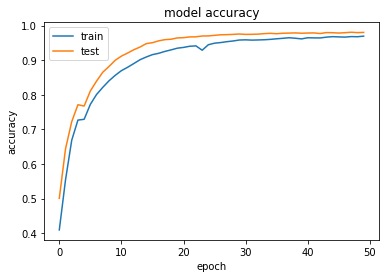

In [51]:
plt.plot(history_final_model.history['acc'])
plt.plot(history_final_model.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

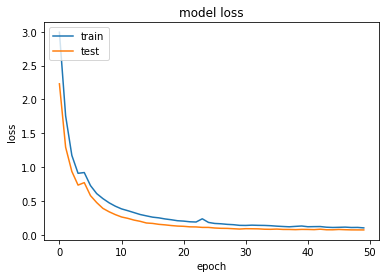

In [52]:
plt.plot(history_final_model.history['loss'])
plt.plot(history_final_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

<font color='red'>***Thoughts on the result:***</font>  
The validation loss is decreasing and it hasn't reached a minimum point, meaning the global optimal hasn't been reached.

## Submission
When you're ready to submit, complete the following steps:
1. Review the [rubric](https://review.udacity.com/#!/rubrics/1004/view) to ensure your submission meets all requirements to pass
2. Generate an HTML version of this notebook

  - Run the next cell to attempt automatic generation (this is the recommended method in Workspaces)
  - Navigate to **FILE -> Download as -> HTML (.html)**
  - Manually generate a copy using `nbconvert` from your shell terminal
```
$ pip install nbconvert
$ python -m nbconvert machine_translation.ipynb
```
  
3. Submit the project

  - If you are in a Workspace, simply click the "Submit Project" button (bottom towards the right)
  
  - Otherwise, add the following files into a zip archive and submit them 
  - `helper.py`
  - `machine_translation.ipynb`
  - `machine_translation.html`
    - You can export the notebook by navigating to **File -> Download as -> HTML (.html)**.

### Generate the html

**Save your notebook before running the next cell to generate the HTML output.** Then submit your project.

In [53]:
# Save before you run this cell!
!!jupyter nbconvert *.ipynb

['[NbConvertApp] Converting notebook machine_translation.ipynb to html',
 '[NbConvertApp] Writing 497313 bytes to machine_translation.html',
 '[NbConvertApp] Converting notebook machine_translation-zh.ipynb to html',
 '[NbConvertApp] Writing 328614 bytes to machine_translation-zh.html']

## Optional Enhancements

This project focuses on learning various network architectures for machine translation, but we don't evaluate the models according to best practices by splitting the data into separate test & training sets -- so the model accuracy is overstated. Use the [`sklearn.model_selection.train_test_split()`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function to create separate training & test datasets, then retrain each of the models using only the training set and evaluate the prediction accuracy using the hold out test set. Does the "best" model change?